<a href="https://colab.research.google.com/github/SimonAndren/CS146/blob/main/Final_Project_CO2_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 - Introduction to code

This codebook contains the work for my Final Project in CS146. The task is to model historical CO2 measurement upto date from Mauna Loa in Hawaii.

The model will be used to generate distributions over the posterior parameters for the CO2 concentrations at the location. These parameters will then be used to 
1. Estimate the CO2 levels upto 2060 within a 95% interval. 
2. Estimate when the alarming 450 PPM concentrations will be reach (if current trend continues)

Three models will be presented. The first one is a direct replica of the model provided to us for the task. The second and third model will be a improved versions. Discussion of the model and it's priors for the parameters will be discussed later in the code book.

# Section 2 -  Data processing

The data processing will be limited. This is because the dependent variable requires no processes and the only indepedent variable is Date. The date of the measurement will be modified to a numerical value. Each year elapsed since the date for the first measurement is equal to 1. The first measurement will thus have time 0 and each following measurement will be a value proportional to the elapsed time. I.e.e three months since the first measurement has time 0.25.

One of the models is a exponential model. To allow for a growth factor larger than 1 (after rounding), I noticed that I needed to have the time range from 0 to 1, as oppose to ~ 60. I therefore also include a column with the relative time where 1 is the most recent measurement and 0 the oldest 

In [1]:
#import all the packages for data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pystan
import scipy.stats as sts
import seaborn as sns

In [2]:
#Import the CSV file of all the measurements
#url = "/content/drive/MyDrive/Classes/CS146/Final Project/weekly_in_situ_co2_mlo.csv"
url = "weekly_in_situ_co2_mlo.csv"


df = pd.read_csv(url) #Download the datafile
df.columns = ["Date", "CO2"] #add columns 

#Convert the date column to date string objects which will make it easier to modify
df["Date"] = pd.to_datetime(df["Date"])

print(df.info()) #print out info of the dataset
print(df.head()) #print out the head of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3209 non-null   datetime64[ns]
 1   CO2     3209 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.3 KB
None
        Date     CO2
0 1958-04-05  317.31
1 1958-04-12  317.69
2 1958-04-19  317.58
3 1958-04-26  316.48
4 1958-05-03  316.95


We notice that there are no null datapoints and we can thus ignore any NA converting.

The data is in weekly measurements and stored as date objects. We will need to convert them to something that can be interpreted by stan as a parameter value for the STAN model. I will use days since first observation, i.e. the first observation is at day 0.

In [3]:
#add a column for the elaped days since first observation
df["Time_days"] = (df.Date - df["Date"][0]).dt.days

#add a column for the elapsed years as well
df["Time_year"] = df["Time_days"]/365.25

#add a column for the relative elapsed time since first measurement
df["Rel_time"] = df["Time_days"]/df["Time_days"][df.shape[0]-1]

print(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


           Date     CO2  Time_days  Time_year  Rel_time
0    1958-04-05  317.31          0   0.000000  0.000000
1    1958-04-12  317.69          7   0.019165  0.000305
2    1958-04-19  317.58         14   0.038330  0.000610
3    1958-04-26  316.48         21   0.057495  0.000915
4    1958-05-03  316.95         28   0.076660  0.001220
...         ...     ...        ...        ...       ...
3204 2021-01-16  414.84      22932  62.784394  0.998780
3205 2021-01-23  415.46      22939  62.803559  0.999085
3206 2021-01-30  415.68      22946  62.822724  0.999390
3207 2021-02-06  416.91      22953  62.841889  0.999695
3208 2021-02-13  416.45      22960  62.861054  1.000000

[3209 rows x 5 columns]


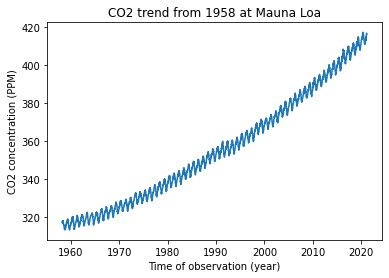

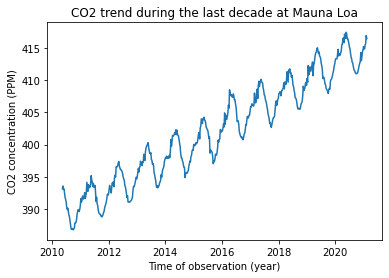

In [4]:
#Plot the historical trend
plt.plot(df.loc[:, ["Date"]], df.loc[:, ["CO2"]])
plt.xlabel("Time of observation (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("CO2 trend from 1958 at Mauna Loa")
plt.show()

#Plot the last decades trend
plt.plot(df.loc[2650:, ["Date"]], df.loc[2650:, ["CO2"]])
plt.xlabel("Time of observation (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("CO2 trend during the last decade at Mauna Loa")
plt.show()

# Section 3 - Stan Models + Posteriors + Priors

Text below almost identical to the PDF report.

Firstly, there appears to be a very steady annual increase in the CO2 measurements. This aligns with the expectations since anthropogenic emissions are continuously emitting atmospheric carbon previously stored as fossil fuel. Secondly, there is also an oscillating trend. This is assumed to be from the seasonality in sinks and source from non-anthropogenic agents, mostly plants. We thus expect to see an oscillating pattern with a period of 1 year. Lastly, there is some measurement noise, which is likely due to random fluctuations in CO2 concentrations and possible measurement errors.

The steady annual trend is in the first model assumed to be linear. There is thus a fixed increase in the CO2 levels. This assumption is flawed since the CO2 emissions has accelerated during the last 60 years as the human population has grown likewise many other factors that impact CO2 emissions such as meat consumption per person etc. The linear model assumes a fixed first derivative. There are two improved models, one is quadratic and one is exponential. These assume an accelerating increase in CO2 levels with time. This is closer to the actual world since the population growth and increasing consumption accelerates the increase. The quadratic model predicts a constant acceleration while the exponential model predicts an accelerating acceleration. The acceleration could be accelerating if the population increase is accelerating or if positive feedback loops are triggered. One of these feedbacks is the oxidation of carbon soil that happens as the tundra thaws. As the tundra thaws, one of the results is that the reduced organic carbon will start oxidizing, releasing CO2. This will further increase the temperature and thus the rate at which the tundra thaws, increasing the rate at which further CO2 is released.

The oscillating trend is thought to be seasonal, thus having a period of 1 year. Both models will have the same model for the seasonal trend. From the CO2 trend during the last decade, it appears to follow a sinus curve. The model will thus be a sinus curve. 

The measurement noise will be the same for each model and is incorporated by having the CO2 measurements come from a normal distribution with the mean of the model expected value, and a sigma quantifying these fluctuations. 

For the linear model, we have 5 parameters. The choice of priors will be discussed below. To note is that the observed dataset is very large (above 3000 measurements). The impact from the prior is thus expected to not have very high influence on the posterior. All prior are relatively uninformative.

C1 - Interception. The prior for C1 is drawn from a normal distribution centered around 280 with a SD of 30. 280 is set since it's approximately the mean CO2 levels during the 1800's century. It's drawn from a normal distribution since deviation is through to occur additively and symmetric around the mean. It's worth noting that while the normal distribution allows for negative concentration (which can't happen) the SD relative to the mean is very little (1/10th) that obtaining a negative prior is virtually impossible. 

C2 - Slope. The prior for C2 is drawn from a normal distribution truncated at 0 and centered around 0.5 with a SD of 0.5. 0.5 is the approximate annual increase in CO2 levels during the 1800's century. Having the SD to be the same as the mean result in a relatively uninformed prior, i.e. 2 SD away is ~ 1.5. It's drawn from a truncated distribution since we don't believe the slope should be negative as we saw from the previous historical trend from the 1800's.

C3 - Magnitude of seasonal change. The prior for C3 is drawn from a cauchy with X0 5 and scale 1. In the implementation, C3 is truncated at 0 it’s the amplitude of the oscillation, and should by convention be a positive number. Previous data didn't give me any accurate information about the magnitude and it's thus set to be relatively uninformative.

C4 - Period. The period represents the relative lag from feb, in which the seasonality starts to follow the sinus curve. I have no idea to how large this lag will be, i.e. Does the increase from the mean start in feb (C4 = 0) or jan (C4 = 2*pi)? Because of this, the prior should be set to a uniform distribution from 0 to 2*pi. However, due to some unknown reason, having the prior go from 0 to 2*pi caused the model to not converge, it was experimentally noticed that when the prior is set to go to only pi, convergence occurred. But again, due to the large dataset, this is not expected to have any significant result on the final posterior distribution. 

C5 - Sigma. The standard deviation will be positive. However, I don't know the magnitude of random noise. It is therefore set to come from a truncated cauchy distribution with a X0 of 4 and a scale of 1.
____________
For the two improved models, the assumptions and priors for the seasonality will remain the same. In the quadratic, a new term was added (C3-Quadratic term) and for the exponential, C1 is instead the initial value, and C2 is the growth factor.

Quadratic C3 - The quadratic term is believed to be non-zero and positive as there has been an acceleration during the 1800's century. However, due to being quadratic, it's believed to be very little since it's not the dominant trend (compared to the linear). If it's large, then the quadratic will overpower the linear trend. Because of this, it comes from a normal with mu = 0 and sd = 0.5. The reason for being from a prior allowing for negative values is because from experiments, it's noticed that else the parameters don't converge. This is likely due to all chains starting from a positive value very far from the true value, and the chains thus don't coverage as the algorithm doesn't find the posterior space.

Exponential C1 - The prior for the initial value will be exactly the same as for the linear interception. This is because the starting point is believed to be the same for both models.

Exponential C2 - The growth factor for the exponential is believed to be above 1 since there is an increase. Since the growth factor is a rate, (rate of increase) it's believed to come from a gamma distribution. The gamma is truncated at 1 to be positive and given alpha = 2 and beta = 1 to be uninformative.



In [5]:
stan_model_linear =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x[N];   // Elapsed year, independent
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real mu_C2;            // Prior mu for C2
  real sd_C2;            //Prior sd for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C5;            // Prior mu for C5
  real sd_C5;            //Prior sd for C5

}

parameters {
  real C1;                         // Interception
  real C2;                         // Slope
  real<lower=0> C3;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C4;     // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C5;                // Measurement standard deviation
}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ normal(mu_C2, sd_C2) T[0,];       //Prior C2
  C3 ~ cauchy(mu_C3, sd_C3);       //Prior C3
  C4 ~ uniform(0, pi());           //Prior C4
  C5 ~ cauchy(mu_C5, sd_C5);       //Prior C5

  for (n in 1:N)
    y[n] ~ normal(C1 + C2*x[n]+ C3*sin(2*pi()*x[n] + C4), C5);
}
"""

stan_model_quadratic =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x[N];   // Elapsed days, independent
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real mu_C2;            // Prior mu for C2
  real sd_C2;            //Prior sd for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C4;            // Prior mu for C4
  real sd_C4;            //Prior sd for C4

  real mu_C6;            //Prior mu for C6
  real sd_C6;            //Prior sd for C6

}

parameters {
  real C1;                         // Interception
  real C2;                // Slope
  real C3;                // Quadratic term
  real<lower=0> C4;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C5;     // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C6;                // Measurement standard deviation

}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ normal(mu_C2, sd_C2) T[0,];       //Prior C2
  C3 ~ normal(mu_C3, sd_C3);       //Prior C3
  C4 ~ cauchy(mu_C4, sd_C4);       //Prior seasonal amplitude
  C5 ~ uniform(0, pi());        //Prior for period
  C6 ~ cauchy(mu_C6, sd_C6);       //Prior for sigma

  for (n in 1:N)
    y[n] ~ normal(C1 + C2*x[n] + C3*square(x[n]) + C4*sin(2*pi()*x[n] + C5), C6);
}
"""

stan_model_expon =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x_1[N];   // Relative Elapsed year, for exponential function
  real<lower=0> x_2[N];   // Absolute Elapsed year, for seasonal variation
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real alpha;            // Prior alpha for C2
  real beta;            //Prior beta for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C5;            // Prior mu for C3
  real sd_C5;            //Prior sd for C3

}

parameters {
  real<lower=300>C1;                   // Original amoung, interception
  real<lower=1> C2;                // Growth factor
  real<lower=0> C3;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C4;   // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C5;                // Measurement standard deviation
}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ gamma(alpha, beta) T[1,];       //Prior C2
  C3 ~ cauchy(mu_C3, sd_C3);       //Prior C3
  C4 ~ uniform(0, 2*pi());       //Prior C4
  C5 ~ cauchy(mu_C5, sd_C5);       //Prior C5

  for (n in 1:N)
    y[n] ~ normal(C1 * pow(C2, x_1[n]) + C3*sin(2*pi()*x_2[n] + C4), C5);
}
"""

In [6]:
model_linear = pystan.StanModel(model_code=stan_model_linear)
model_quadratic = pystan.StanModel(model_code=stan_model_quadratic)
model_expon = pystan.StanModel(model_code=stan_model_expon)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76dd20e3dedac0180a57589e545d2afa NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_42ec1c06bade63d455b1a65c23f8beb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43ff7568796ced52073b997f0545b9ad NOW.


In [7]:
#standata for the linear model
stan_data_linear = {
  "N": df.shape[0],
  "x": df.Time_year.values,
  "y": df.CO2.values,
  "mu_C1": 280,
  "sd_C1": 30,
  "mu_C2": 2,            
  "sd_C2": 1,
  "mu_C3": 5,           
  "sd_C3": 1,           
  "mu_C5": 4,           
  "sd_C5": 1     
}
#standata for the quadratic model
stan_data_quadratic = {
  "N": df.shape[0],
  "x": df.Time_year.values,
  "y": df.CO2.values,
  "mu_C1": 280,
  "sd_C1": 30,
  "mu_C2": 2,            
  "sd_C2": 1,
  "mu_C3": 0,           
  "sd_C3": 0.5,           
  "mu_C4": 5,           
  "sd_C4": 1,
  "mu_C6": 4,           
  "sd_C6": 1,  

}

#standata for the exponential model
stan_data_expon = {
  "N": df.shape[0],
  "x_1": df.Rel_time.values,
  "x_2": df.Time_year.values,
  "y": df.CO2.values,
  "mu_C1": 280,
  "sd_C1": 30,
  "alpha": 2,            
  "beta": 1,
  "mu_C3": 5,           
  "sd_C3": 1,           
  "mu_C5": 4,           
  "sd_C5": 1         
}

In [8]:
linear_results = model_linear.sampling(data = stan_data_linear)

print(linear_results)

Inference for Stan model: anon_model_76dd20e3dedac0180a57589e545d2afa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   305.66  2.5e-3   0.14 305.38 305.56 305.66 305.76 305.94   3402    1.0
C2     1.59  6.8e-5 4.0e-3   1.59   1.59   1.59    1.6    1.6   3486    1.0
C3     2.84  1.5e-3    0.1   2.65   2.77   2.83    2.9   3.03   4201    1.0
C4     1.28  6.1e-4   0.04   1.21   1.26   1.28    1.3   1.35   3555    1.0
C5     3.99  7.8e-4   0.05    3.9   3.96   3.99   4.03    4.1   4203    1.0
lp__  -6047    0.04   1.59  -6051  -6048  -6047  -6046  -6045   1561    1.0

Samples were drawn using NUTS at Wed Apr 21 18:06:34 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
quad_results = model_quadratic.sampling(data = stan_data_quadratic)

print(quad_results)

Inference for Stan model: anon_model_42ec1c06bade63d455b1a65c23f8beb5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   314.73  1.7e-3   0.05 314.63  314.7 314.74 314.77 314.84   1000    1.0
C2     0.75  1.1e-4 3.8e-3   0.74   0.75   0.75   0.75   0.76   1123    1.0
C3     0.01  1.6e-6 5.8e-5   0.01   0.01   0.01   0.01   0.01   1298    1.0
C4     2.86  5.4e-4   0.02   2.81   2.84   2.86   2.87    2.9   2156    1.0
C5     1.28  1.3e-4 8.7e-3   1.26   1.27   1.28   1.29    1.3   4289    1.0
C6     0.98  2.3e-4   0.01   0.96   0.97   0.98   0.99   1.01   2885    1.0
lp__  -1554    0.05   1.71  -1558  -1555  -1554  -1553  -1552   1374    1.0

Samples were drawn using NUTS at Wed Apr 21 18:32:31 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
co

In [10]:
expon_results = model_expon.sampling(data = stan_data_expon)

print(expon_results)

Inference for Stan model: anon_model_43ff7568796ced52073b997f0545b9ad.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   307.69  1.8e-3    0.1 307.49 307.62 307.69 307.75 307.89   3119    1.0
C2     1.33  1.2e-5 6.9e-4   1.33   1.33   1.33   1.33   1.33   3165    1.0
C3     2.84  1.2e-3   0.07   2.71   2.79   2.84    2.9   2.99   4189    1.0
C4     1.28  4.5e-4   0.03   1.23   1.26   1.28    1.3   1.33   3463    1.0
C5     2.99  5.9e-4   0.04   2.92   2.96   2.99   3.02   3.07   4076    1.0
lp__  -5117    0.04   1.52  -5121  -5118  -5117  -5116  -5115   1576    1.0

Samples were drawn using NUTS at Wed Apr 21 18:34:07 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The linear model converged with a Rhat at 1.0 for all the parameters and with large effective samples sizes for each. The confidence intervals for the interception and slope was very narrow indicating that a large confidence in the slope for the historical trend. The parameters related to the seasonal variation is a bit wider, but no cause to any worry. 

The quadratic model converged with a Rhat at 1.0 for all the parameters and with large effective samples sizes for each. The confidence intervals for all the parameters was very narrow indicating that a large confidence in all parameter values.

The exponential model also converged with a Rhat close to 1 for all the parameter and large effective sample sizes. The parameters with most uncertainly was: C3 and C4, and with least uncertaintly was C1 and C2. This was expected since C1 and C2 are related to the historical trend, while C3, C4 are related to the seasonal variation.

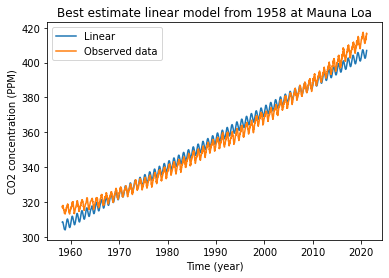

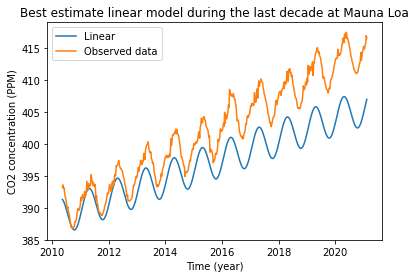

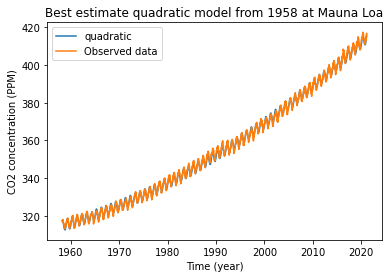

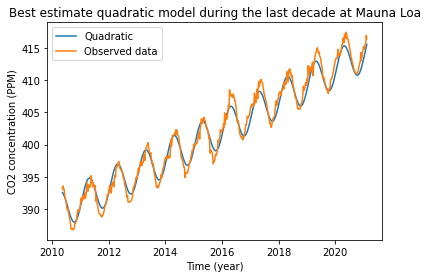

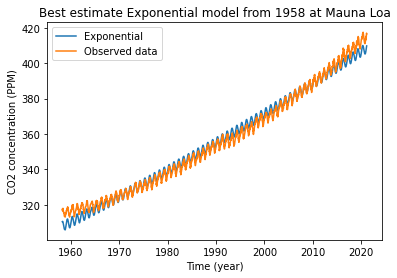

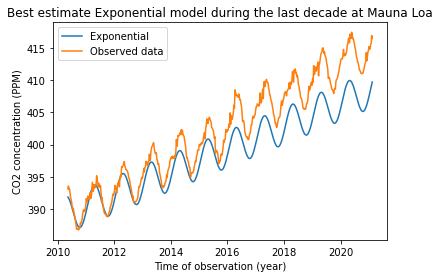

In [11]:
#It this cell, the posterior parameters means will be plotted over the original data

#Get the year data
years = np.array(df.loc[:, ["Time_year"]])
years_rel = np.array(df.loc[:, ["Rel_time"]])

#Extract the posterior samples
linear_samples = linear_results.extract()
quad_samples = quad_results.extract()
expon_samples = expon_results.extract()

linear_y_hat = (linear_samples["C1"].mean() +               #The interception
                linear_samples["C2"].mean() * years +       #The slope
                linear_samples["C3"].mean() *               #Seasonal variation
                np.sin(2*np.pi*years + linear_samples["C4"].mean()))  #Seasonal variation

quad_y_hat = (quad_samples["C1"].mean() +               #The interception
                quad_samples["C2"].mean() * years +       #The slope
                quad_samples["C3"].mean() * np.square(years) + #The quadratic term
                quad_samples["C4"].mean() *               #Seasonal variation
                np.sin(2*np.pi*years + quad_samples["C5"].mean()))  #Seasonal variation                


expon_y_hat = (expon_samples["C1"].mean() *                 #The starting value
               expon_samples["C2"].mean() ** years_rel +       #Growth rate and year
               expon_samples["C3"].mean() *                 #Seasonal variation
               np.sin(2*np.pi*years + expon_samples["C4"].mean()))  #Seasonal variation


#Plot the best estimate for linear model and observed data
plt.plot(df.loc[:, ["Date"]], linear_y_hat, label = "Linear")
plt.plot(df.loc[:, ["Date"]], df.loc[:, ["CO2"]], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate linear model from 1958 at Mauna Loa")
plt.legend()
plt.show()

plt.plot(df.loc[2650:, ["Date"]], linear_y_hat[2650:], label = "Linear")
plt.plot(df.loc[2650:, ["Date"]], df.loc[2650:, ["CO2"]], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate linear model during the last decade at Mauna Loa")
plt.legend()
plt.show()

#Plot the best estimate quadratic model and observed data
plt.plot(df.loc[:, ["Date"]], quad_y_hat, label = "quadratic")
plt.plot(df.loc[:, ["Date"]], df.loc[:, ["CO2"]], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate quadratic model from 1958 at Mauna Loa")
plt.legend()
plt.show()

plt.plot(df.loc[2650:, ["Date"]], quad_y_hat[2650:], label = "Quadratic")
plt.plot(df.loc[2650:, ["Date"]], df.loc[2650:, ["CO2"]], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate quadratic model during the last decade at Mauna Loa")
plt.legend()
plt.show()

#Plot the exponential model and observed data
plt.plot(df.loc[:, ["Date"]], expon_y_hat, label = "Exponential")
plt.plot(df.loc[:, ["Date"]], df.loc[:, ["CO2"]], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate Exponential model from 1958 at Mauna Loa")
plt.legend()
plt.show()

plt.plot(df.loc[2650:, ["Date"]], expon_y_hat[2650:], label = "Exponential")
plt.plot(df.loc[2650:, ["Date"]], df.loc[2650:, ["CO2"]], label = "Observed data")
plt.xlabel("Time of observation (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate Exponential model during the last decade at Mauna Loa")
plt.legend()
plt.show()

From plotting the best estimate parameter value against the same time period, it appears that the quadratic model explains the obseved trends the best. We will thus decide upon the quadratic model for predictive inference. The quadratic model will however first be investigated a bit more.

From the stan summary, we see that all chains converge as well as each parameter have a very large effective sample size. Because of this, it's reasonable to assume that each parameter sample is very independent and it's not necissary to do a autocorrelation plot. However, we want to investigate the relationship between the variables. This will be done using a pair plot.

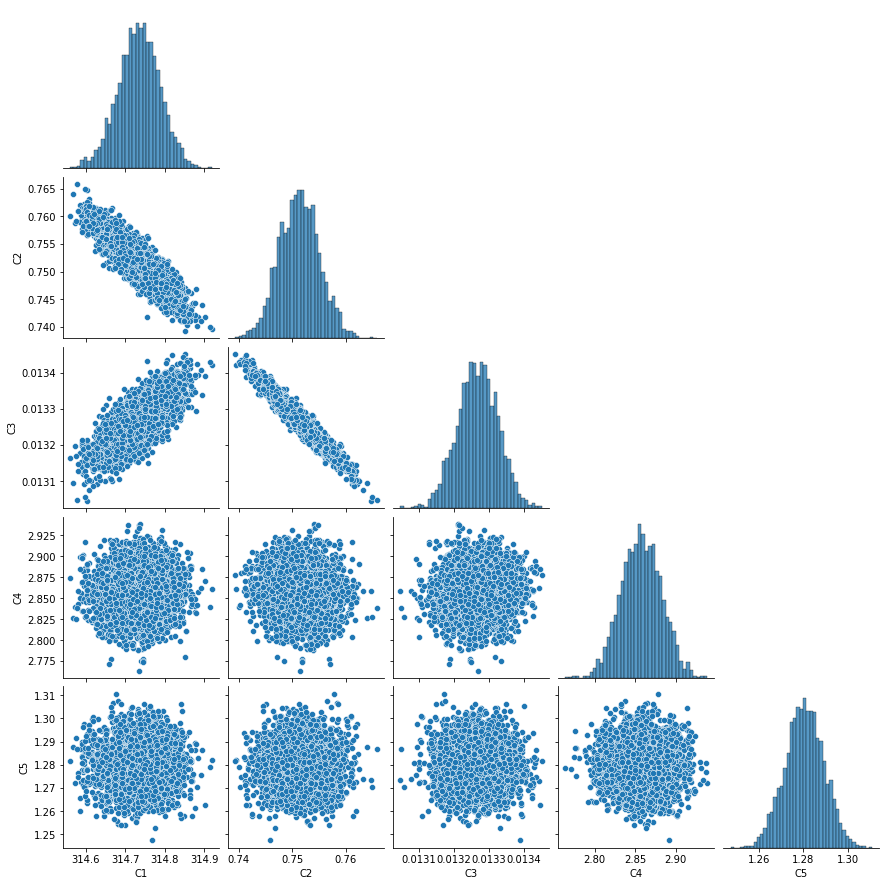

In [12]:
#Pair plot

#Dataframe for all the parameter samples
parameter_frame = pd.DataFrame(np.transpose([quad_samples["C1"], quad_samples["C2"], 
                                             quad_samples["C3"], quad_samples["C4"], 
                                             quad_samples["C5"]]), 
                               columns = ["C1", "C2", "C3", "C4", "C5"])

#Make a pairplot for all the parameters using the sns 
sns.pairplot(parameter_frame, vars = ["C1", "C2", "C3", "C4", "C5"], 
             dropna = True, corner=True)

From the pairplot, we can see that the samples from each parameter is normally distributed. This aligns with our prior predictions as we assumed many of the parameters to be from a normal distribution.

As for the pair plots. There is no appearent correlation between samples from parameters relating to  seasonality and any other parameter. The pairplots are equally scattered in all directions.

As for the pairplots when both parameters are from the annual trend, there is a larger correlation. There is a negative correlation between C1 and C2 as well as C2 and C3. The relationship between C1 and C2 is negative since a high intercept (i.e. large starting CO2 level) should  correspond to a slower linear increase to still have a good fit to the data. The negative correlation between C2 and C3 is due to the same reasonallity, a high linear slope should correspond to a low quadratic term to still have a good fit to the data. The positive correlation between C1 and C3 is probably due to relationship both parameters has to C2. A high C1 would likely correspond to a low C2, which corresponds to a high C3. This would explain the positive correlation between C1 and C3 

In [13]:
#MSE and RMSE 

#compute MSE
MSE = np.mean(np.square(np.transpose(quad_y_hat)-df.CO2.values))

#Compure the root MSE
RMSE = np.sqrt(MSE)

print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {RMSE}")

Mean Squared Error: 0.9646793584586958
Root Mean Squared Error: 0.9821809194128625


Both the MSE and RMSE was very small compared to the value of the CO2 concentrations. It is much less than 1%. We conclude that the model values and the observed values align pretty well. 

# Section 4 - Predictive inference

For the predictive inference, the best estimate and 95% interval for the progression of CO2 levels is computed.

In [14]:
#This functions compute the predicted CO2 levels for the quadratic models

def quad_predictor(C1, C2, C3, C4, C5, abs_year):
  """Doc string"""

  #Predicted Y values
  pred_y = (C1 + C2 * abs_year + C3*np.square(abs_year) + C4* np.sin(2*np.pi*abs_year + C5)) 

  return pred_y

In [15]:
#Dates to predict for
dates = pd.date_range(df.Date[df.shape[0]-1], '2061-02-13', freq = "W")

#The absolute years
abs_year = (dates - df["Date"][0]).days / 365.25

#Dataset for predicted levels for each parameter sample
quad_prediction = np.array([quad_predictor(quad_samples["C1"][i],
                                      quad_samples["C2"][i],
                                      quad_samples["C3"][i],
                                      quad_samples["C4"][i], 
                                      quad_samples["C5"][i],
                                      abs_year) for 
                              i in range(len(linear_samples["C1"]))])

#The mean "Best estimate"
quad_mean = np.mean(quad_prediction, axis = 0)

#The 95% interval
quad_confint = np.percentile(quad_prediction, axis = 0, q = [2.5, 97.5])


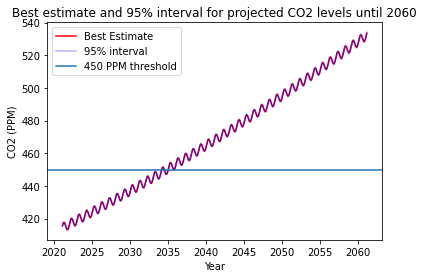

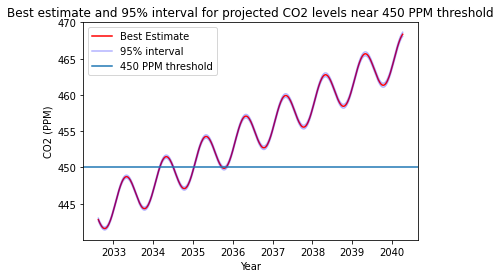

In [16]:
#plot the best estimate and the 95% interval up until 2060
plt.plot(dates, quad_mean, color = "red", label = "Best Estimate")
plt.plot(dates, quad_confint[0], color = "blue", alpha = 0.3, label = "95% interval")
plt.plot(dates, quad_confint[1], color = "blue", alpha = 0.3)
plt.axhline(450, label = "450 PPM threshold")
plt.title("Best estimate and 95% interval for projected CO2 levels until 2060")
plt.xlabel("Year")
plt.ylabel("CO2 (PPM)")
plt.legend()
plt.show()

#plot the best estimate and the 95%  interval near the 450 PPM threshold
plt.plot(dates[600:1000], quad_mean[600:1000], color = "red", label = "Best Estimate")
plt.plot(dates[600:1000], quad_confint[0][600:1000], color = "blue", alpha = 0.3, label = "95% interval")
plt.plot(dates[600:1000], quad_confint[1][600:1000], color = "blue", alpha = 0.3)
plt.axhline(450, label = "450 PPM threshold")
plt.title("Best estimate and 95% interval for projected CO2 levels near 450 PPM threshold")
plt.xlabel("Year")
plt.ylabel("CO2 (PPM)")
plt.legend()
plt.show()